In [ ]:
## Install Simpy Library in Colab (We need Simpy to simulate our complicated custom environment) 
!pip install simpy

## Imports ##

In [ ]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as tkr
import random
from sklearn import preprocessing
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from collections import deque
import tensorflow_probability as tfp
import seaborn as sns
from scipy.stats import *
from sklearn.mixture import GaussianMixture
import scipy.stats as st
import warnings
import simpy
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
# Define Agent Class
class Agent():
  def __init__(self,features_number,actions_number):
    self.features_number=features_number
    self.actions_number=actions_number
    self.memory = deque(maxlen=2000)
    self.gamma =0.99 # Discount_factor
    self.epsilon = 0.2
    self.optimizer = tf.keras.optimizers.RMSprop()
    self.actor_network=self.actor_model()
    self.actor_Tnetwork=self.actor_model()
    self.critic_network=self.critic_model()
    self.critic_Tnetwork=self.critic_model()
  def actor_model(self):
    model = keras.Sequential(  layers=[
                keras.Input(shape=(self.features_number,)),
                layers.Dense(90, activation="tanh", name="relu_layer"),
                layers.Dense(90, activation="tanh", name="relu2_layer"),
                layers.Dense(90, activation="tanh", name="relu3_layer"),
                layers.Dense(30, activation="tanh", name="relu4_layer"),
                layers.Dense(self.actions_number, activation="linear", name="linear")
            ],
            name="policy")
    return model
  def sample_action(self,state):
    sampled_action=self.action_distribution(state).sample().numpy()
    return sampled_action[0]
 
  def critic_model(self):
    model = Sequential()
    model.add(Dense(120,activation='tanh',input_dim=self.features_number))
     # model.add(Dropout(0.1))
    model.add(Dense(60,activation='tanh'))
     # model.add(Dropout(0.25))
    model.add(Dense(30,activation='tanh'))
    model.add(Dense(self.actions_number, activation="linear"))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model
  
  def action_distribution(self, observations):
        logits = self.actor_network(observations)
        return tfp.distributions.Categorical(logits=logits)
  def log_probs(self,observations,actions):
    probs=self.actor_network(np.array(observations))
    log_p=[]
    for i in range(len(actions)):
      log_p.append(np.log(probs[i][actions[i]]))
    return log_p
  def update_networks(self):
        epoch=1
        state, action, reward, next_state=list(),list(),list(),list()
        batch=random.sample(self.memory,k=128) #Tuple(state, action, reward, next_state)
        for mini_batch in (batch):
            state.append(mini_batch[0][0])
            action.append(mini_batch[1])
            next_state.append(mini_batch[2][0])
            reward.append(mini_batch[3])
        future_reward=np.amax(self.critic_Tnetwork.predict(np.array(next_state)),axis=1)
        target = np.array(reward)+ self.gamma * future_reward
        target_f = self.critic_network.predict(np.array(state))
        # calculate advantages
        advantages=np.zeros(128)
        for i in range(128):
          advantages[i]= target[i] - target_f[i][action[i]]
        for i in range(128):
          target_f[i][action[i]]=target[i]
        X_Train , Y_Train = np.array(state), target_f 
        
        # update critic network
        self.critic_network.fit(X_Train, Y_Train, epochs=epoch, batch_size =64, verbose=0)
        # preparing inputs to update policy network
        observations = tf.convert_to_tensor(np.array(state))
        actions = tf.convert_to_tensor(np.array(action))
        advantages = tf.convert_to_tensor(np.array(advantages))
        log_prob = tf.convert_to_tensor(self.log_probs(observations,actions))
        with tf.GradientTape() as tape:
            log_prob = self.action_distribution(observations).log_prob(actions)
            loss = tf.math.reduce_mean(log_prob * tf.cast(advantages, tf.float32))
        grads = tape.gradient(loss, self.actor_network.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.actor_network.trainable_weights))
  def sample_from_critic(self,state):
    sample=np.argmax(self.critic_network(state))
    return sample

## Mounting at drive ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Data ##

In [ ]:
intervals=pd.read_csv('/content/drive/My Drive/time_intervals.csv')
df=pd.read_csv('/content/drive/My Drive/time_location.csv')
df.columns=['time','x','y']
intervals.columns=['intervals']
df

,time,x,y
0,23:57:51,35.588577,51.441051
1,23:58:18,35.751425,51.468405
2,0:00:35,35.781357,51.307325
3,0:00:53,35.770903,51.450354
4,0:01:52,35.728643,51.184010
...,...,...,...
22943,23:54:31,35.738207,51.304881
22944,23:54:51,35.750058,51.525621
22945,23:54:55,35.502409,51.216174
22946,23:56:32,35.712569,51.109073


## Extract Spatial Distribution of Demands ##

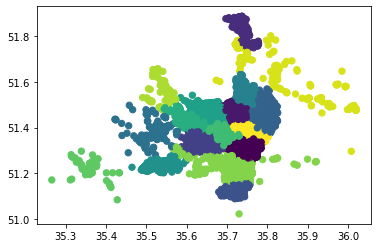

In [ ]:
gmm = GaussianMixture(n_components=17)
data=df.drop('time',axis=1)
gmm.fit(data)
#predictions from gmm
labels = gmm.predict(data)
plt.scatter(data["x"], data['y'], c=labels,s=40, cmap='viridis')
plt.show()

## Extract Temporal Distribution of Demands ##

In [ ]:
def get_best_distribution(data):
    dist_names = ["expon","gamma","logistic","loggamma","rayleigh","exponnorm","exponpow","exponweib","skewnorm","chi","chi2","lognorm", "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
best_dist,best_p,params=get_best_distribution(intervals['intervals'])

## Form Patient Object For Recording Important Features Related to Each Patient ##

In [ ]:
class Patient:
    def __init__(self, index, arrival_time):
        self.index = index
        self.time_pickedup = arrival_time
        self.done = False
        self.Queue_Time = 0.
        self.Time_To_Treat=0.
        self.queue_start=0
        self.time_travel=0
        self.treatment_start=0
        self.action=0
        self.priority=0
        self.state=0
        self.next_state=0
        self.reward=0
        self.action=0
        self.alternative_action=0
        self.hospital_name=0
        self.queues_numbers=0
        
        
    def time_to_treat(self, time):
        self.done= True
        self.Time_To_Treat = time
    def queue_time(self, time):
        self.Queue_Time=time

## Learning Agent in Custom Simulated Environment ##

In [ ]:
 def time_intervals():
    return pareto.rvs(6.606780038988145, -309.98478714504665, 310.98478582967186) 
 
def prio_generation():
    if np.random.rand()<0.052:
      return 1
    elif (np.random.rand()>0.052 and np.random.rand()< 0.496):
      return 2
    elif (np.random.rand()>0.496 and np.random.rand()< 0.996):
      return 3
    else:
      return 4
def service_time(priority):
    if priority==1:
        return np.random.exponential(55*12)
    if priority==2:
        return np.random.exponential(65*60)
    if priority==3:
        return np.random.exponential(60*60)
    else:
        return np.random.exponential(25*60)
def time_before_treatment(priority):
    if priority==1:
        return np.random.uniform(1*60,3*60)
    elif priority==2:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    elif priority==3:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    else:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
  
def calc_time_travel(i,j):
    return (((i[0]-j[0])**2+(i[1]-j[1])**2)**0.5)* 20000
 
def assign_cyclically(patientid):
  if patientid%3==0:
    return 2
  elif patientid%2==0:
    return 1
  else:
    return 0
def ems_walkings_one(env,hospital_one):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=1
    print(env.now,'patient walk-in came to hospital one')
    env.process(walkings_service(env,hospital_one,priority,x))
    
def ems_walkings_two(env,hospital_two):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=2
    print(env.now,'patient walk-in came to hospital two')
    env.process(walkings_service(env,hospital_two,priority,x))
 
def ems_walkings_three(env,hospital_three):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=3
    print(env.now,'patient walk-in came to hospital three')
    env.process(walkings_service(env,hospital_three,priority,x))
 
def walkings_service(env,hospital,priority,x):
    # time before hospilitaztion (Greet time + Registration time + Triage)
    yield env.timeout(time_before_treatment(priority))
    with hospital.request(priority=priority) as req:
        yield req
    print(env.now, 'walking patient hospitillized in hospital: ',x)
    yield env.timeout(service_time(priority))
 
def ems_run(env, hospital_one,hospital_two,hospital_three):
    patientid=0
    while True:
        priority=prio_generation()
        yield env.timeout(time_intervals())
        arrival_time=env.now
        patientid+=1
        patient= Patient(patientid,arrival_time)
        patient.priority=priority
        finished_patients=[p for p in patients if p.done]
        print(env.now,f'patient with patient id {patientid}  picked by ambulance')
        location=gmm.sample()[0][0].tolist()
        # calculate distances
        travel_one=calc_time_travel(location,hospital_one_location)
        travel_two=calc_time_travel(location,hospital_two_location)
        travel_three=calc_time_travel(location,hospital_three_location)
        time_travels = [travel_one,travel_two,travel_three]
        # current capacity available in each hospital
        hospital_one_current_capacity=hospital_one.capacity-hospital_one.count +1
        hospital_two_current_capacity=hospital_two.capacity-hospital_two.count +1
        hospital_three_current_capacity=hospital_three.capacity-hospital_three.count +1
        # current queue length of each hospital
        hospital_one_queue= len(hospital_one.queue) +1
        hospital_two_queue= len(hospital_two.queue) +1
        hospital_three_queue= len(hospital_three.queue) +1
        # calculate number of ambulances heading to hospitals (not reached to destination yet)
        
        hospitals_queue=[hospital_one_queue,hospital_two_queue,hospital_three_queue]
        patient.queues_number=hospitals_queue
        # form state input for the model
        z=[x+y for x,y in zip(hospitals_queue,ambulances_in_way_to_hospitals)]
        state= ambulances_in_way_to_hospitals + hospitals_queue + time_travels + [hospital_one_current_capacity]+ [hospital_two_current_capacity]+ [hospital_three_current_capacity] +[patient.priority]
        print('state is  ', state)
        state = np.array(state).reshape(1,len(state)).round(4)
        patient.state=state
        print('hospitals queue situation is:  ', hospitals_queue)
        # we assign 300000 seconds to warmup period and also use thi time to fill the memory of agent
        # in warmup period the destination in 50% of times is chosen based on aggregation of capacity and ambulances in way of hospitals and in the other 50% of times is nerest hospital
        # after warmup we decrease epsilon over time and after 3000000 seconds it will be 0
 
        if env.now<10000:
          action= z.index(min(z))
        else:
          if np.random.rand()<agent.epsilon:
            action= z.index(min(z))
          else:
            action=agent.sample_from_critic(state)
        print('critic prediction of Q Values is : ',agent.critic_network(state))
        ambulances_in_way_to_hospitals[action]=ambulances_in_way_to_hospitals[action]+1
        patient.action=action
        state[0][action]=hospitals_queue[action]+1
        next_state= state
        patient.next_state=next_state
        hospitals=[hospital_one,hospital_two,hospital_three]
        
        destination=hospitals[action]
        patient.time_travel=time_travels[action]
        names=['hospital_one','hospital_two','hospital_three']
        patient.hospital_name=names[action]
        print(env.now,f'patient with patient id {patientid} is heading to {patient.hospital_name}')
        env.process(service(env,destination,patient,hospitals_queue))
        
        
def service(env,hospitals,patient,hospitals_queue):
   #  time travel
    yield env.timeout(patient.time_travel)
    patient.queue_start=env.now
    ambulances_in_way_to_hospitals[patient.action]=ambulances_in_way_to_hospitals[patient.action]-1
#   print(env.now , f'patient with patient id: {patient.index} arrived at {patient.hospital_name}')
    # Greeting time + Registration + Triage Time
    yield env.timeout(time_before_treatment(patient.priority))
    with hospitals.request(priority=patient.priority) as req:
        yield req
        patient.treatment_start=env.now
        patient.time_to_treat(patient.treatment_start - patient.time_pickedup)
        patient_waiting_times.append(patient.Time_To_Treat)
        patient.queue_time(patient.treatment_start - patient.queue_start)
        patients.append(patient)
 
 #       print(env.now , f'patient with patient id: {patient.index} hospitalized at hospital')
        reward = (-((patient.treatment_start - patient.time_pickedup) / 1000) * 4) / patient.priority
        print(' reward is   ', reward)
        rewards.append(reward)
        patient.reward=reward
        agent.memory.append([patient.state, patient.action, patient.next_state,patient.reward])
        if (len(patients)>500):
          if len(patients)%5==0:
            agent.update_networks()
    #        print('we updated the networks')
          if len(patients)%100==0:
            agent.actor_Tnetwork.set_weights(agent.actor_network.get_weights())
            agent.critic_Tnetwork.set_weights(agent.critic_network.get_weights())
    #        print(' target networks updated')
 
     #   print(env.now, 'patient hospitillized')
        yield env.timeout(service_time(patient.priority))
    #    print(env.now,'patient departs')
 
     #   print( f'patient with patient id: {patient.index} waited {patient.Queue_Time} in hospital queue')
patientid=0
patients=[]
finished_patients=[]
 
agent = Agent(13,3)
agent.epsilon=0.2
rewards=[]
patient_waiting_times=[]
hospital_one_location=[35.706316,51.380267] # Imam Khomeili Hospital
hospital_two_location=[35.722066,51.332374] # Ebne Sina Hospital
hospital_three_location=[35.68082,51.38800] # Loghmane Hakim Hospital
ambulances_in_way_to_hospitals=[1,1,1]
env = simpy.Environment()
hospital_one=simpy.PriorityResource(env, capacity=30)
hospital_two=simpy.PriorityResource(env, capacity=30)
hospital_three=simpy.PriorityResource(env, capacity=30)
env.process(ems_run(env,hospital_one,hospital_two,hospital_three))
env.process(ems_walkings_one(env,hospital_one))
env.process(ems_walkings_two(env,hospital_two))
env.process(ems_walkings_three(env,hospital_three))
env.run(until=10000000)

248.25337100768297 patient with patient id 1  picked by ambulance
state is   [1, 1, 1, 1, 1, 1, 3627.0291972392397, 4542.386775968907, 3599.9720123529446, 31, 31, 31, 4]
hospitals queue situation is:   [1, 1, 1]
critic prediction of Q Values is :  tf.Tensor([[ 0.07838857 -1.219143    0.6651154 ]], shape=(1, 3), dtype=float32)
248.25337100768297 patient with patient id 1 is heading to hospital_one
295.4297699027331 patient with patient id 2  picked by ambulance
state is   [2, 1, 1, 1, 1, 1, 2323.811271106026, 3332.1246849509616, 2067.092696910841, 31, 31, 31, 3]
hospitals queue situation is:   [1, 1, 1]
critic prediction of Q Values is :  tf.Tensor([[-0.02224404 -1.4183338   0.7618199 ]], shape=(1, 3), dtype=float32)
295.4297699027331 patient with patient id 2 is heading to hospital_two
378.87038645921695 patient with patient id 3  picked by ambulance
state is   [2, 2, 1, 1, 1, 1, 2886.7081641201835, 3336.8286937293756, 2382.9776163438637, 31, 31, 31, 2]
hospitals queue situation is:   

KeyboardInterrupt: ignored

In [ ]:
means=[]
x=[]
for i in range(0,len(patients)-100,50):
  for j in range(50):
    x.append(rewards[i+j])
  means.append(np.mean((x)))
print(means)
print(len(means))

[-7.625569794280733, -7.61837721373526, -7.7791202066418315, -8.141217389332878, -8.381001522594081, -8.664840785520319, -9.371119268215313, -9.734975478763255, -10.123816553232176, -10.315155262165252, -10.315529233988144, -10.441554676486318, -10.8704610998514, -11.416572499575377, -11.939460603040517, -12.159362652077263, -11.907361606290694, -11.655710385428815, -11.44007377720132, -11.234768707519077, -11.116224459575202, -10.964038039866981, -10.910256866788592, -10.82672889651749, -10.75054505656757, -10.735159930642745, -10.733432639465024, -10.846656898666497, -10.753839482541046, -10.729327270159809, -10.87429099092709, -11.021596996899374, -11.05011320431051, -11.284216040900912, -11.605984446436025, -12.00469790090985, -12.232503210366113, -12.619389337544774, -12.844783522045267, -13.080740919664233, -13.280436664962929, -13.4277088245024, -14.157979358874274, -14.999083345596684, -15.704213758406281, -16.342396045632643, -16.737313513483524, -17.27388974336464, -17.613716

Text(0.5, 1.0, 'mean of rewards plot')

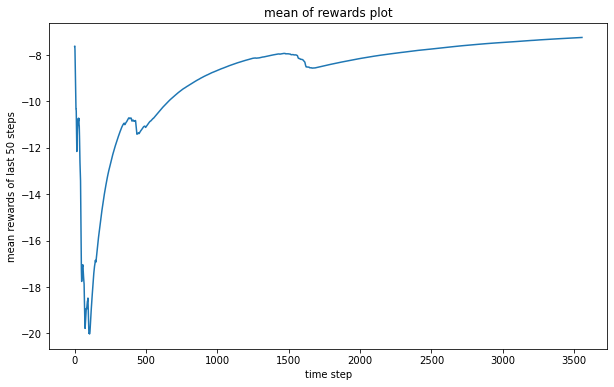

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(means[2000,:])
plt.xlabel('time step')
plt.ylabel('mean rewards of last 50 steps')
plt.title('mean of rewards plot')

In [ ]:
agent.critic_network.save("/content/drive/My Drive/primary_model" + "1"+ "_network.h5")

Test Agent's Performance


In [ ]:
 
def time_intervals():
    return pareto.rvs(6.606780038988145, -309.98478714504665, 310.98478582967186) 
 
def prio_generation():
    if np.random.rand()<0.052:
      return 1
    elif (np.random.rand()>0.052 and np.random.rand()< 0.496):
      return 2
    elif (np.random.rand()>0.496 and np.random.rand()< 0.996):
      return 3
    else:
      return 4
def service_time(priority):
    if priority==1:
        return np.random.exponential(55*12)
    if priority==2:
        return np.random.exponential(65*60)
    if priority==3:
        return np.random.exponential(60*60)
    else:
        return np.random.exponential(25*60)
def time_before_treatment(priority):
    if priority==1:
        return np.random.uniform(1*60,3*60)
    elif priority==2:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    elif priority==3:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    else:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
  
def calc_time_travel(i,j):
    return (((i[0]-j[0])**2+(i[1]-j[1])**2)**0.5)* 20000
 
def assign_cyclically(patientid):
  if patientid%3==0:
    return 2
  elif patientid%2==0:
    return 1
  else:
    return 0
def ems_walkings_one(env,hospital_one):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=1
    print(env.now,'patient walk-in came to hospital one')
    env.process(walkings_service(env,hospital_one,priority,x))
    
def ems_walkings_two(env,hospital_two):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=2
    print(env.now,'patient walk-in came to hospital two')
    env.process(walkings_service(env,hospital_two,priority,x))
 
def ems_walkings_three(env,hospital_three):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=3
    print(env.now,'patient walk-in came to hospital three')
    env.process(walkings_service(env,hospital_three,priority,x))
 
def walkings_service(env,hospital,priority,x):
    # time before hospilitaztion (Greet time + Registration time + Triage)
    yield env.timeout(time_before_treatment(priority))
    with hospital.request(priority=priority) as req:
        yield req
    print(env.now, 'walking patient hospitillized in hospital: ',x)
    yield env.timeout(service_time(priority))
 
def ems_run(env, hospital_one,hospital_two,hospital_three):
    patientid=0
    while True:
        priority=prio_generation()
        yield env.timeout(time_intervals())
        arrival_time=env.now
        patientid+=1
        patient= Patient(patientid,arrival_time)
        patient.priority=priority
        finished_patients=[p for p in patients if p.done]
        print(env.now,f'patient with patient id {patientid}  picked by ambulance')
        location=gmm.sample()[0][0].tolist()
        # calculate distances
        travel_one=calc_time_travel(location,hospital_one_location)
        travel_two=calc_time_travel(location,hospital_two_location)
        travel_three=calc_time_travel(location,hospital_three_location)
        time_travels = [travel_one,travel_two,travel_three]
        # current capacity available in each hospital
        hospital_one_current_capacity=hospital_one.capacity-hospital_one.count +1
        hospital_two_current_capacity=hospital_two.capacity-hospital_two.count +1
        hospital_three_current_capacity=hospital_three.capacity-hospital_three.count +1
        # current queue length of each hospital
        hospital_one_queue= len(hospital_one.queue) +1
        hospital_two_queue= len(hospital_two.queue) +1
        hospital_three_queue= len(hospital_three.queue) +1
        # calculate number of ambulances heading to hospitals (not reached to destination yet)
        
        hospitals_queue=[hospital_one_queue,hospital_two_queue,hospital_three_queue]
        patient.queues_number=hospitals_queue
        # form state input for the model
        z=[x+y for x,y in zip(hospitals_queue,ambulances_in_way_to_hospitals)]
        state= ambulances_in_way_to_hospitals + hospitals_queue + time_travels + [hospital_one_current_capacity]+ [hospital_two_current_capacity]+ [hospital_three_current_capacity] +[patient.priority]
        print('state is  ', state)
        state = np.array(state).reshape(1,len(state)).round(4)
        patient.state=state
        print('hospitals queue situation is:  ', hospitals_queue)
        # we assign 300000 seconds to warmup period and also use thi time to fill the memory of agent
        # in warmup period the destination in 50% of times is chosen based on aggregation of capacity and ambulances in way of hospitals and in the other 50% of times is nerest hospital
        # after warmup we decrease epsilon over time and after 3000000 seconds it will be 0
 
       
        if np.random.rand()<agent.epsilon:
            action= z.index(min(z))
        else:
            action=agent.sample_from_critic(state)
        print('critic prediction of Q Values is : ',agent.critic_network(state))
        ambulances_in_way_to_hospitals[action]=ambulances_in_way_to_hospitals[action]+1
        patient.action=action
        state[0][action]=hospitals_queue[action]+1
        next_state= state
        patient.next_state=next_state
        hospitals=[hospital_one,hospital_two,hospital_three]
        
        destination=hospitals[action]
        patient.time_travel=time_travels[action]
        names=['hospital_one','hospital_two','hospital_three']
        patient.hospital_name=names[action]
        print(env.now,f'patient with patient id {patientid} is heading to {patient.hospital_name}')
        env.process(service(env,destination,patient,hospitals_queue))
        
        
def service(env,hospitals,patient,hospitals_queue):
   #  time travel
    yield env.timeout(patient.time_travel)
    patient.queue_start=env.now
    ambulances_in_way_to_hospitals[patient.action]=ambulances_in_way_to_hospitals[patient.action]-1
#   print(env.now , f'patient with patient id: {patient.index} arrived at {patient.hospital_name}')
    # Greeting time + Registration + Triage Time
    yield env.timeout(time_before_treatment(patient.priority))
    with hospitals.request(priority=patient.priority) as req:
        yield req
        patient.treatment_start=env.now
        patient.time_to_treat(patient.treatment_start - patient.time_pickedup)
        patient_waiting_times.append(patient.Time_To_Treat)
        patient.queue_time(patient.treatment_start - patient.queue_start)
        patients.append(patient)
 
 #       print(env.now , f'patient with patient id: {patient.index} hospitalized at hospital')
        reward = (-((patient.treatment_start - patient.time_pickedup) / 1000) * 4) / patient.priority
        print(' reward is   ', reward)
        rewards.append(reward)
        patient.reward=reward
        agent.memory.append([patient.state, patient.action, patient.next_state,patient.reward])
        if (len(patients)>500):
          if len(patients)%5==0:
            agent.update_networks()
    #        print('we updated the networks')
          if len(patients)%100==0:
            agent.actor_Tnetwork.set_weights(agent.actor_network.get_weights())
            agent.critic_Tnetwork.set_weights(agent.critic_network.get_weights())
    #        print(' target networks updated')
 
     #   print(env.now, 'patient hospitillized')
        yield env.timeout(service_time(patient.priority))
    #    print(env.now,'patient departs')
 
     #   print( f'patient with patient id: {patient.index} waited {patient.Queue_Time} in hospital queue')
patientid=0
patients=[]
finished_patients=[]
 
agent = Agent(13,3)
agent.critic_network=load_model("/content/drive/My Drive/primary_model2_network.h5")
agent.epsilon=0.2
rewards=[]
patient_waiting_times=[]
hospital_one_location=[35.706316,51.380267] # Imam Khomeili Hospital
hospital_two_location=[35.722066,51.332374] # Ebne Sina Hospital
hospital_three_location=[35.68082,51.38800] # Loghmane Hakim Hospital
ambulances_in_way_to_hospitals=[1,1,1]
env = simpy.Environment()
hospital_one=simpy.PriorityResource(env, capacity=30)
hospital_two=simpy.PriorityResource(env, capacity=30)
hospital_three=simpy.PriorityResource(env, capacity=30)
env.process(ems_run(env,hospital_one,hospital_two,hospital_three))
env.process(ems_walkings_one(env,hospital_one))
env.process(ems_walkings_two(env,hospital_two))
env.process(ems_walkings_three(env,hospital_three))
env.run(until=4000000)

Streaming output truncated to the last 5000 lines.
state is   [10, 10, 10, 1, 1, 1, 1313.1904381530283, 885.5724841865381, 1353.164704493234, 17, 12, 15, 4]
hospitals queue situation is:   [1, 1, 1]
critic prediction of Q Values is :  tf.Tensor([[-9.723198 -9.795488 -9.899999]], shape=(1, 3), dtype=float32)
3950347.4544294607 patient with patient id 70314 is heading to hospital_one
3950402.0956734265 patient with patient id 70315  picked by ambulance
state is   [10, 9, 10, 1, 1, 1, 4286.7584716351175, 5001.765415350469, 4448.740376819384, 17, 12, 15, 2]
hospitals queue situation is:   [1, 1, 1]
critic prediction of Q Values is :  tf.Tensor([[-23.048794 -23.311243 -23.049452]], shape=(1, 3), dtype=float32)
3950402.0956734265 patient with patient id 70315 is heading to hospital_one
3950408.9663927606 patient with patient id 70316  picked by ambulance
state is   [11, 9, 9, 1, 1, 1, 1382.6137726560758, 2317.218342863128, 933.5645144075766, 17, 12, 15, 2]
hospitals queue situation is:   [1,

In [ ]:
finished_patients=[]
for p in patients:
  if p.done==True:
    finished_patients.append(p)

In [ ]:
x=[]
for p in finished_patients:
  x.append(p.Time_To_Treat)
print(np.mean(x))

3851.038530486574


## Calculate Average Time Before Start of Hospilitation At Emergency Room (Totall Waiting Time)

In [ ]:
x_one,x_two,x_three,x_four=[],[],[],[]
for p in patients:
  if p.priority==1:
    x_one.append(p.Time_To_Treat)
  elif p.priority==2:
    x_two.append(p.Time_To_Treat)
  elif p.priority==3:
    x_three.append(p.Time_To_Treat)
  else:
    x_four.append(p.Time_To_Treat)
print(np.mean(x_one))
print(np.mean(x_two))
print(np.mean(x_three))
print(np.mean(x_four))

2186.742606523958
3791.345778791295
3894.1524960167117
4262.425299655893


## Calculate Average Travel Time For Patients ##

In [ ]:
travel_time_one,travel_time_two,travel_time_three,travel_time_four=[],[],[],[]
for p in patients:
  if p.priority==1:
    travel_time_one.append(p.time_travel)
  elif p.priority==2:
    travel_time_two.append(p.time_travel)
  elif p.priority==3:
    travel_time_three.append(p.time_travel)
  else:
    travel_time_four.append(p.time_travel)
print(np.mean(travel_time_one))
print(np.mean(travel_time_two))
print(np.mean(travel_time_three))
print(np.mean(travel_time_four))

2053.050493780592
2056.579313591988
2064.1152250665045
2070.824429262788


## Investigate Current Policy of National EMS for Allocation: Allocate ambulances to nearest hospital ##


In [ ]:
 
def time_intervals():
    return pareto.rvs(6.606780038988145, -309.98478714504665, 310.98478582967186) 
 
def prio_generation():
    if np.random.rand()<0.052:
      return 1
    elif (np.random.rand()>0.052 and np.random.rand()< 0.496):
      return 2
    elif (np.random.rand()>0.496 and np.random.rand()< 0.996):
      return 3
    else:
      return 4
def service_time(priority):
    if priority==1:
        return np.random.exponential(55*12)
    if priority==2:
        return np.random.exponential(65*60)
    if priority==3:
        return np.random.exponential(60*60)
    else:
        return np.random.exponential(25*60)
def time_before_treatment(priority):
    if priority==1:
        return np.random.uniform(1*60,3*60)
    elif priority==2:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    elif priority==3:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
    else:
        return np.random.uniform(2*60,5*60)+np.random.uniform(5*60,10*60)+np.random.uniform(15*60,20*60)
  
def calc_time_travel(i,j):
    return (((i[0]-j[0])**2+(i[1]-j[1])**2)**0.5)* 22000
 
def assign_cyclically(patientid):
  if patientid%3==0:
    return 2
  elif patientid%2==0:
    return 1
  else:
    return 0
def ems_walkings_one(env,hospital_one):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=1
    print(env.now,'patient walk-in came to hospital one')
    env.process(walkings_service(env,hospital_one,priority,x))
    
def ems_walkings_two(env,hospital_two):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=2
    print(env.now,'patient walk-in came to hospital two')
    env.process(walkings_service(env,hospital_two,priority,x))
 
def ems_walkings_three(env,hospital_three):
    priority=prio_generation()
    yield env.timeout(10*60)
    x=3
    print(env.now,'patient walk-in came to hospital three')
    env.process(walkings_service(env,hospital_three,priority,x))
 
def walkings_service(env,hospital,priority,x):
    # time before hospilitaztion (Greet time + Registration time + Triage)
    yield env.timeout(time_before_treatment(priority))
    with hospital.request(priority=priority) as req:
        yield req
    print(env.now, 'walking patient hospitillized in hospital: ',x)
    yield env.timeout(service_time(priority))
 
def ems_run(env, hospital_one,hospital_two,hospital_three):
    patientid=0
    while True:
        priority=prio_generation()
        yield env.timeout(time_intervals())
        arrival_time=env.now
        patientid+=1
        patient= Patient(patientid,arrival_time)
        patient.priority=priority
        finished_patients=[p for p in patients if p.done]
        print(env.now,f'patient with patient id {patientid}  picked by ambulance')
        location=gmm.sample()[0][0].tolist()
        # calculate distances
        travel_one=calc_time_travel(location,hospital_one_location)
        travel_two=calc_time_travel(location,hospital_two_location)
        travel_three=calc_time_travel(location,hospital_three_location)
        time_travels = [travel_one,travel_two,travel_three]
        action= time_travels.index(min(time_travels))
        patient.action=action

        hospitals=[hospital_one,hospital_two,hospital_three]
        
        destination=hospitals[action]
        patient.time_travel=time_travels[action]
        names=['hospital_one','hospital_two','hospital_three']
        patient.hospital_name=names[action]
        print(env.now,f'patient with patient id {patientid} is heading to {patient.hospital_name}')
        env.process(service(env,destination,patient))
        
        
def service(env,hospitals,patient):
   #  time travel
    yield env.timeout(patient.time_travel)
    # Greeting time + Registration + Triage Time
    yield env.timeout(time_before_treatment(patient.priority))
    with hospitals.request(priority=patient.priority) as req:
        yield req
        patient.treatment_start=env.now
        patient.time_to_treat(patient.treatment_start - patient.time_pickedup)
        patient_waiting_times.append(patient.Time_To_Treat)
        patient.queue_time(patient.treatment_start - patient.queue_start)
        patients.append(patient)
        yield env.timeout(service_time(patient.priority))

patientid=0
patients=[]
finished_patients=[]
rewards=[]
patient_waiting_times=[]
hospital_one_location=[35.706316,51.380267] # Imam Khomeili Hospital
hospital_two_location=[35.722066,51.332374] # Ebne Sina Hospital
hospital_three_location=[35.68082,51.38800] # Loghmane Hakim Hospital
ambulances_in_way_to_hospitals=[1,1,1]
env = simpy.Environment()
hospital_one=simpy.PriorityResource(env, capacity=30)
hospital_two=simpy.PriorityResource(env, capacity=30)
hospital_three=simpy.PriorityResource(env, capacity=30)
env.process(ems_run(env,hospital_one,hospital_two,hospital_three))
env.process(ems_walkings_one(env,hospital_one))
env.process(ems_walkings_two(env,hospital_two))
env.process(ems_walkings_three(env,hospital_three))
env.run(until=4000000)

Streaming output truncated to the last 5000 lines.
4054154.452945479 patient with patient id 71604  picked by ambulance
4054154.452945479 patient with patient id 71604 is heading to hospital_three
4054159.5410040286 patient with patient id 71605  picked by ambulance
4054159.5410040286 patient with patient id 71605 is heading to hospital_three
4054170.20597275 patient with patient id 71606  picked by ambulance
4054170.20597275 patient with patient id 71606 is heading to hospital_one
4054233.0875115786 patient with patient id 71607  picked by ambulance
4054233.0875115786 patient with patient id 71607 is heading to hospital_three
4054272.405718156 patient with patient id 71608  picked by ambulance
4054272.405718156 patient with patient id 71608 is heading to hospital_three
4054283.7801206354 patient with patient id 71609  picked by ambulance
4054283.7801206354 patient with patient id 71609 is heading to hospital_one
4054446.7599137183 patient with patient id 71610  picked by ambulance
405

KeyboardInterrupt: ignored

In [ ]:
finished_patients=[]
for p in patients:
  if p.done==True:
    finished_patients.append(p)

In [ ]:
x=[]
for p in finished_patients:
  x.append(p.Time_To_Treat)
print(np.mean(x))

4293.782151542742


In [ ]:
x_one,x_two,x_three,x_four=[],[],[],[]
for p in patients:
  if p.priority==1:
    x_one.append(p.Time_To_Treat)
  elif p.priority==2:
    x_two.append(p.Time_To_Treat)
  elif p.priority==3:
    x_three.append(p.Time_To_Treat)
  else:
    x_four.append(p.Time_To_Treat)
print(np.mean(x_one))
print(np.mean(x_two))
print(np.mean(x_three))
print(np.mean(x_four))

2170.6837059851136
3834.651028950924
4028.9894806109237
5822.191701878721


In [ ]:
travel_time_one,travel_time_two,travel_time_three,travel_time_four=[],[],[],[]
for p in patients:
  if p.priority==1:
    travel_time_one.append(p.time_travel)
  elif p.priority==2:
    travel_time_two.append(p.time_travel)
  elif p.priority==3:
    travel_time_three.append(p.time_travel)
  else:
    travel_time_four.append(p.time_travel)
print(np.mean(travel_time_one))
print(np.mean(travel_time_two))
print(np.mean(travel_time_three))
print(np.mean(travel_time_four))

2021.6426578838766
2060.5893279636457
2068.7162289422113
2061.0744748583634
